# Lab 05


In [1]:
# %%capture doesn't display output
%%capture
!wget https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_POIs.zip -O nyc_poi.zip
!wget https://github.com/dbdmg/data-science-lab/raw/master/datasets/US_FlightDelayData.zip -O fdd.zip

UsageError: Line magic function `%%capture` not found.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## New York Point Of Interest

The _New York Point Of Interest_ dataset collects a sub-sample of the point of interests (POI) available in
the city of New York. It contains the coordinates of each point of interest and the category to which it
belongs to, specifying the _type_ of the POI, for each POI _category_. There are _four_ possible categories of POIs:
_amenity, shop, public_transport_ and _highway_.
The fields available in the dataset are:
- `@id`: a unique id for each point of interest.
- `@lat`: latitude coordinate of the POI in decimal degrees.
- `@lon`: longitude coordinate of the POI in decimal degrees.
- `amenity name`: if the POI category is amenity its type is reported in this field.
- `shop`: if the POI category is shop its type is reported in this field.
- `public_transport`: if the POI category is public transport its type is reported in this field.
- `highway`: if the POI category is highway its type is reported in this field.
  
To identify which are the POIs belonging only to the New York City municipality, a further file is provided. The _New York City municipality POIs metadata_ file is composed by a single column containing the Ids of the POI of interest of the municipality.

In [3]:
from zipfile import ZipFile

with ZipFile('nyc_poi.zip', 'r') as zipfile:
    zipfile.printdir()

File Name                                             Modified             Size
New_York_City_Map.PNG                          2019-11-07 13:54:28        87105
__MACOSX/._New_York_City_Map.PNG               2019-11-07 13:54:28          211
ny_municipality_pois_id.csv                    2019-11-07 15:50:52       581601
__MACOSX/._ny_municipality_pois_id.csv         2019-11-07 15:50:52          267
pois_all_info                                  2019-11-07 14:56:46      4787894
__MACOSX/._pois_all_info                       2019-11-07 14:56:46          267


In [4]:
files_to_extract = ['New_York_City_Map.PNG', 'ny_municipality_pois_id.csv', 'pois_all_info']
with ZipFile('nyc_poi.zip', 'r') as zipfile:
    for file in files_to_extract:
        zipfile.extract(file)

In [5]:
nyc_df = pd.read_csv('pois_all_info',  sep='\t')
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   @id               77884 non-null  int64  
 1   @type             77884 non-null  object 
 2   @lat              75789 non-null  float64
 3   @lon              75789 non-null  float64
 4   amenity           32271 non-null  object 
 5   name              40790 non-null  object 
 6   shop              12850 non-null  object 
 7   public_transport  10390 non-null  object 
 8   highway           9445 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.3+ MB


/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_2027/3240295855.py:1: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv('pois_all_info',  sep='\t')


In [6]:
import csv
ids = []
with open('ny_municipality_pois_id.csv', 'r') as f:
    for col in csv.reader(f):
        # print(col)
        ids.append(int(col[0]))

In [7]:
# Data Cleaning
# Since each poi has unique id, 
# we have to check which row we have to keep.
# Some ids are repeated
mask = nyc_df['@id'].value_counts() > 1

cnt = mask.sum()
duplicated_ids = mask.iloc[:cnt].index

ids_remove = []
# The second id that is repeated contains less informations. 
# Hence we keep the index and we will remove it
for id in duplicated_ids:
    ids_remove.append((nyc_df[nyc_df['@id'] == id]).index[1])
    
# Obtain same result using drop_duplicates

In [8]:
(nyc_df.drop_duplicates(subset='@id', keep='first', )['@id'].value_counts() == 2).sum()

0

In [9]:
# since it works, we can use inplace=True
nyc_df.drop_duplicates(subset='@id', keep='first', inplace=True)
# Now we can set @id as index and then filter the nyc ids
nyc_df.set_index(keys='@id', inplace=True)

In [10]:
filtered_df = nyc_df.loc[ids]

In [11]:
filtered_df.info() #check inferred types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53530 entries, 42432939 to 6146672068
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   @type             53530 non-null  object 
 1   @lat              53530 non-null  float64
 2   @lon              53530 non-null  float64
 3   amenity           24712 non-null  object 
 4   name              30550 non-null  object 
 5   shop              8717 non-null   object 
 6   public_transport  8376 non-null   object 
 7   highway           7559 non-null   object 
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


In [12]:
filtered_df.head()

,@type,@lat,@lon,amenity,name,shop,public_transport,highway
@id,,,,,,,,
42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN


In [13]:
# check where and how many null values you have
for column in filtered_df.columns:
    print(column, filtered_df[column].isna().sum())

@type 0
@lat 0
@lon 0
amenity 28818
name 22980
shop 44813
public_transport 45154
highway 45971


<AxesSubplot:title={'center':'amenity, threshold=0.8'}>

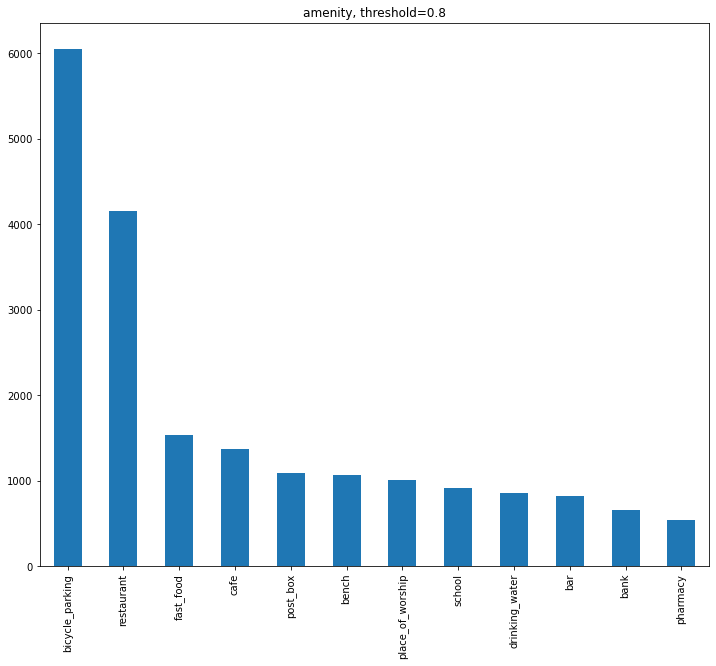

In [52]:
df = filtered_df
column = 'amenity'


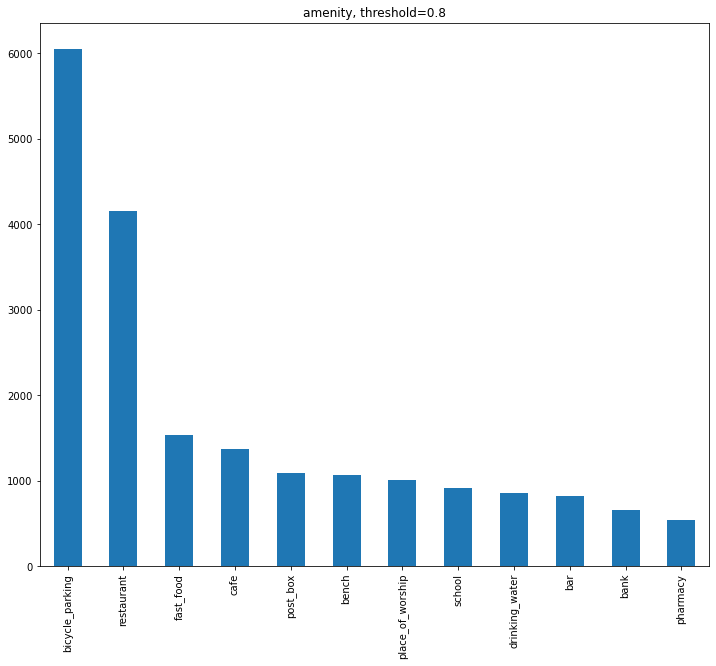

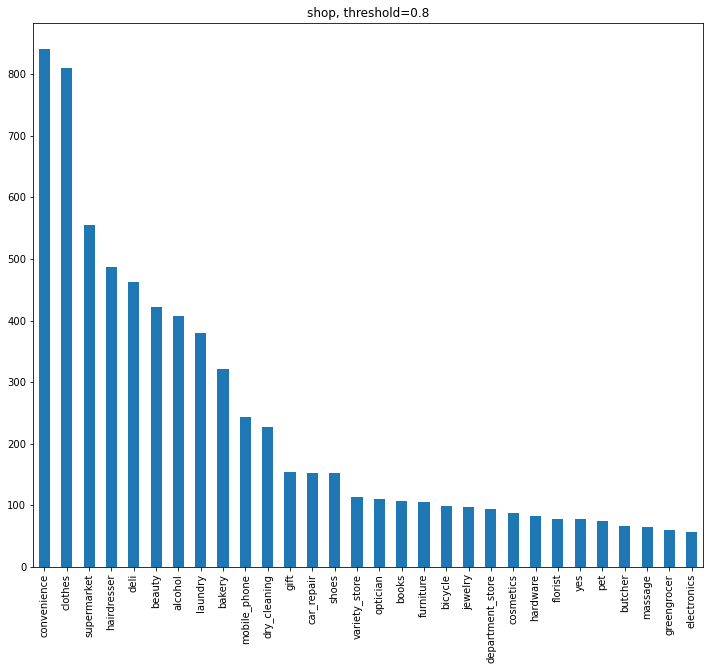

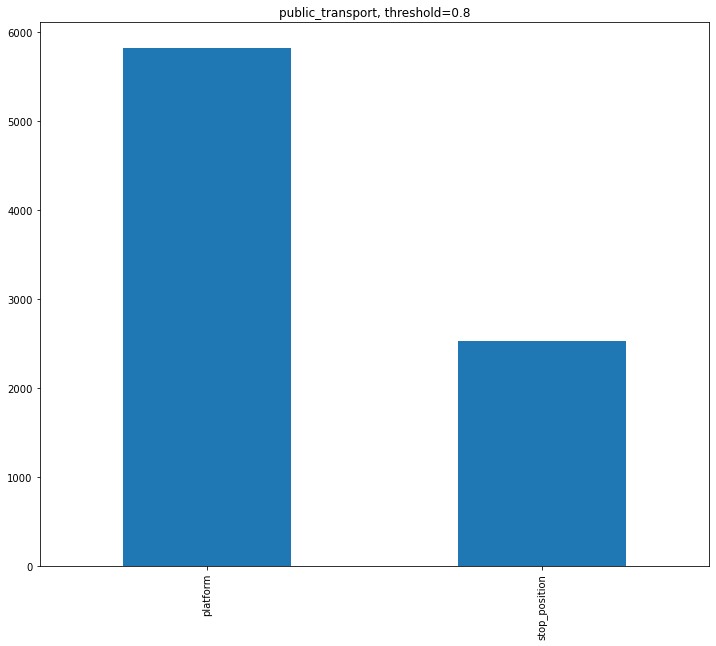

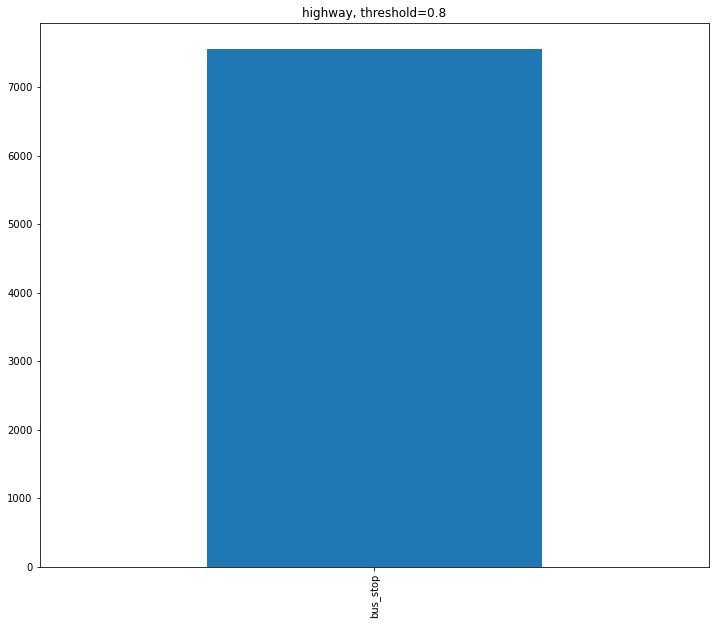

In [54]:
def plot_column_hist(df:pd.DataFrame, column:str, threshold:float=0.5):
    serie = df[column].value_counts()
    threshold=threshold
    idx = (serie.cumsum()/serie.sum() > threshold).values.argmax() # seleziono quelli che non rientrano nell'80% dei casi. l'indice sarà il max
    plt.figure(figsize=(12,10))

    serie.iloc[:idx + 1].plot(kind='bar', title=f'{column}, threshold={threshold}')

columns_to_plot = ['amenity', 'shop', 'public_transport', 'highway']
for col in columns_to_plot:
    plot_column_hist(filtered_df, col, 0.8)

amenity
Green_Market                              AxesSubplot(0.125,0.125;0.775x0.755)
Statue                                    AxesSubplot(0.125,0.125;0.775x0.755)
animal_boarding                           AxesSubplot(0.125,0.125;0.775x0.755)
animal_shelter                            AxesSubplot(0.125,0.125;0.775x0.755)
art_centre                                AxesSubplot(0.125,0.125;0.775x0.755)
                                                          ...                 
waste_basket                              AxesSubplot(0.125,0.125;0.775x0.755)
waste_disposal                            AxesSubplot(0.125,0.125;0.775x0.755)
waste_transfer_station                    AxesSubplot(0.125,0.125;0.775x0.755)
water_point                               AxesSubplot(0.125,0.125;0.775x0.755)
wifi;telephone;device_charging_station    AxesSubplot(0.125,0.125;0.775x0.755)
Length: 130, dtype: object

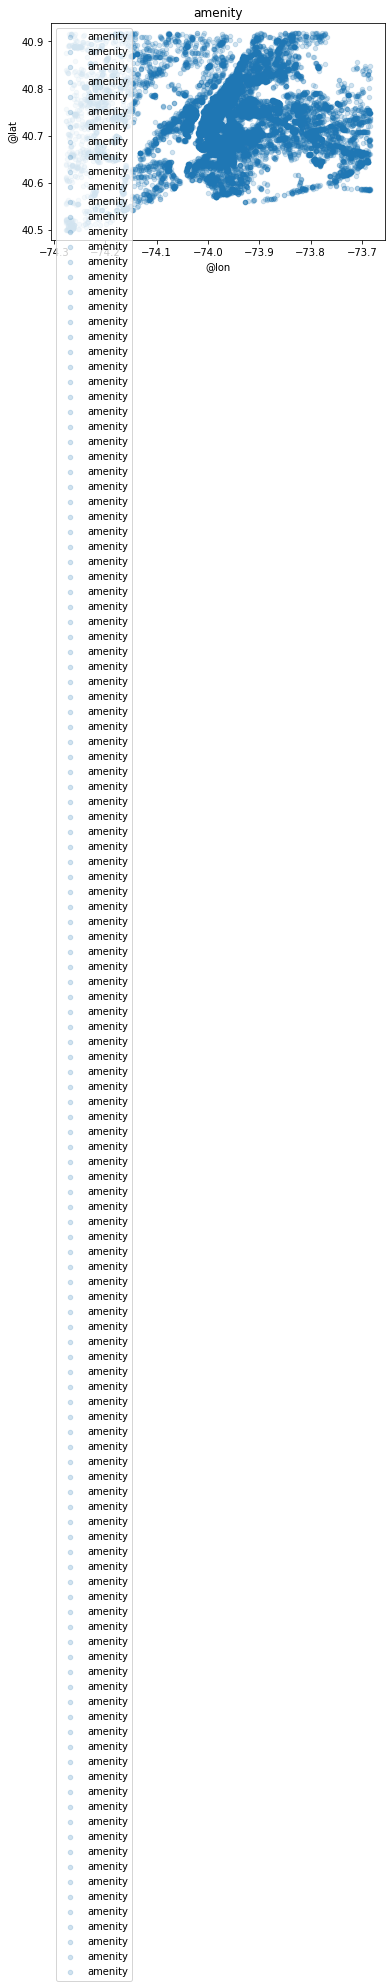

In [26]:
import matplotlib.pyplot as plt
img = plt.imread("New_York_City_Map.PNG")

col = 'amenity'
fig, ax = plt.subplots()
prova = nyc_df[['@lat', '@lon', col]].dropna()

# min_x, max_x = min(prova['@lon']) - .01, max(prova['@lon']) + .01
# min_y, max_y = min(prova['@lat']) - .01, max(prova['@lat']) + .01
# ax.imshow(img, extent=[min_x, max_x, min_y, max_y])
# prova.plot(x='@lon', y='@lat', kind='scatter', alpha=.2, label=col, ax=ax, title=f'{col}')

prova.groupby(by=col).plot(x='@lon', y='@lat', kind='scatter', alpha=.2, label=col, ax=ax, title=f'{col}')

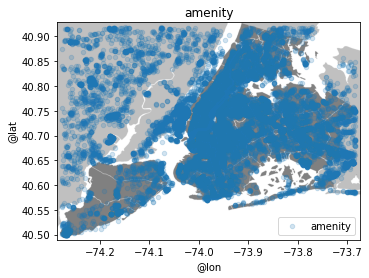

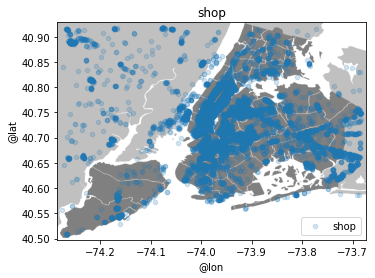

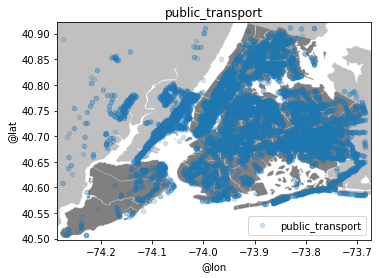

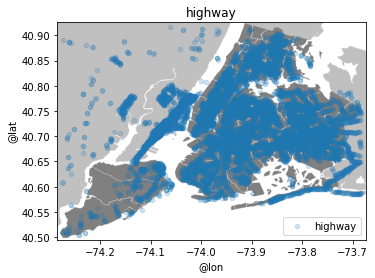

In [22]:
import matplotlib.pyplot as plt
img = plt.imread("New_York_City_Map.PNG")


colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:pink']
for column, color in zip(columns_to_plot, colors):
    fig, ax = plt.subplots()
    prova = nyc_df[['@lat', '@lon', column]].dropna()
    min_x, max_x = min(prova['@lon']) - .01, max(prova['@lon']) + .01
    min_y, max_y = min(prova['@lat']) - .01, max(prova['@lat']) + .01
    ax.imshow(img, extent=[min_x, max_x, min_y, max_y])
    prova.plot(x='@lon', y='@lat', kind='scatter', alpha=.2, label=column, ax=ax, title=f'{column}')

<AxesSubplot:xlabel='@lon', ylabel='@lat'>

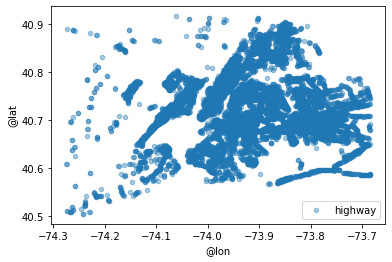

In [ ]:
for col in columns_to_plot:
    lat_ser = nyc_df[['@lat', '@lon', col]]
    lon_ser = nyc_df[['@lon', col]]
# We need latitude as well as longitude.
# In a first approach I'll remove each row that contains a NaN value.
# In a further research we can keep rows in which we have latitude and
# longitude but not the third column
prova = nyc_df[['@lat', '@lon', col]].dropna()
prova.plot(x='@lon', y='@lat', kind='scatter', label=col, alpha=.4)


In [ ]:
columns_to_plot
nyc_df.head()

for col in columns_to_plot:
    lat_ser = nyc_df[['@lat', col]]
    lon_ser = nyc_df[['@lon', col]]


,@type,@lat,@lon,amenity,name,shop,public_transport,highway
@id,,,,,,,,
42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN


## Flight Delay Data

Measuring the performance of flight carriers (e.g. American Airlines, EasyJet) is extremely important for
the transportation department and, for this reason, all the information related to each flight are constantly
monitored and collected in huge databases by the Department of Transportation. To the aim of this laboratory, just a small set of information has been extracted.

The dataset contains the Carrier On-Time Performance information collected from 01-01-2017 until 31-01-2017 for all the flights in the United States. Each row represents a flight in a specific day.

Some of the most useful fields in the dataset are:
- `FL_DATE`: day of the flight in format YYYY-mm-dd.
- `TAIL_NUM`: aircraft registration number, unique to a single aircraft.
- `UNIQUE_CARRIER`: flight carrier id.
- `FL_NUM`: number of the flight.
- `ORIGIN`: departure airport code.
- `DEST`: destination airport code.
- `CRS_DEP_TIME`: scheduled departure time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)
- `DEP_TIME`: actual departure time (local time: HHMM)
- `DEP_DELAY`: overall delay at departure. Difference in minutes (floating point number) between sched-
uled and actual departure time. Early departures set to 0.
- `CRS_ARR_TIME`: scheduled arrival time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)
- `ARR_TIME`: actual arrival time (local time: HHMM)
- `ARR_DELAY`: overall delay. Difference in minutes (floating point number) between scheduled and
actual arrival time. Early arrivals show negative numbers.
- `CARRIER_DELAY`: delay in minutes (floating point number) caused by the carrier.
- `WEATHER_DELAY`: delay in minutes (floating point number) caused by the weather.
- `NAS_DELAY`: delay in minutes (floating point number) caused by the National Air System (NAS).
- `SECURITY_DELAY`: delay in minutes (floating point number) caused by the security.
- `LATE_AIRCRAFT_DELAY`: delay in minutes (floating point number) caused by the aircraft.

There are some other fields in this dataset. You can explore them, understand what they represents and
whether they are significant or not for your analysis.

In [ ]:
from zipfile import ZipFile

with ZipFile('fdd.zip', 'r') as zipfile:
    zipfile.printdir()

File Name                                             Modified             Size
831394006_T_ONTIME.csv                         2019-12-10 05:10:20     92160796


In [ ]:
with ZipFile('fdd.zip', 'r') as zipfile:
    zipfile.extractall()

In [ ]:
fdd_df = pd.read_csv('831394006_T_ONTIME.csv')
fdd_df.head()

,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
0,2017-01-01,AA,19805,N787AA,1,12478,1247803,31703,JFK,"New York, NY",...,1209.0,27.0,0.0,NaN,27.0,0.0,0.0,0.0,0.0,NaN
1,2017-01-01,AA,19805,N783AA,2,12892,1289204,32575,LAX,"Los Angeles, CA",...,1809.0,42.0,0.0,NaN,34.0,0.0,8.0,0.0,0.0,NaN
2,2017-01-01,AA,19805,N791AA,4,12892,1289204,32575,LAX,"Los Angeles, CA",...,2040.0,42.0,0.0,NaN,7.0,0.0,0.0,0.0,35.0,NaN
3,2017-01-01,AA,19805,N391AA,5,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",...,1749.0,97.0,0.0,NaN,77.0,0.0,20.0,0.0,0.0,NaN
4,2017-01-01,AA,19805,N346AA,6,13830,1383002,33830,OGG,"Kahului, HI",...,642.0,42.0,0.0,NaN,0.0,0.0,42.0,0.0,0.0,NaN
